## Text Summarization using machine learning techniques

This notebook implements and describe a soluction to the text summarization problem, using an extractive approach. We develop a model based on clustering of sentences previously embedded. We create k clusters of similar sentences, then for every cluster we select the sentence closest to its centroid. 

Now we describe the main steps involved:
1.	Data preprocess and cleaning (Done previously in another notebook).
2.	Sentence embedding using pretrained vectors

Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation. Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned based on the usage of words. This allows words that are used in similar ways to result in having similar representations, naturally capturing their meaning. A well-trained set of word vectors will place similar words close to each other in that space. The words oak, elm and birch might cluster in one corner, while war, conflict and strife huddle together in another.

GloVe, algorithm is an extension to the word2vec method for efficiently learning word vectors, is an unsupervised learning algorithm that constructs an explicit word-context or word co-occurrence matrix using statistics across the whole text corpus.[9]

3.	Sentence clustering
Once the sentences are embedded we apply a K-Means clustering method to group the sentences in k clusters. Each cluster of sentence embeddings can be interpreted as a set of semantically similar sentences whose meaning can be expressed by just one candidate sentence in the summary.

4.	Select the most representative sentence of each cluster
The candidate sentence chosen in every cluster is the one whose vector representation is closest to the cluster center.

5.	Ordering the sentences to form the summary
Candidate sentences corresponding to each cluster are then ordered to form a summary. The order of the candidate sentences in the summary is determined by the positions of the sentences in their corresponding clusters in the original document


### Importing the libraries

We will use the rouge library to calculate the ROUGE metrics to evaluate the results.This library is independent from the "official" ROUGE script (aka. ROUGE-155) and results may be slighlty different,but it is very easy to use.


In [3]:
!pip install rouge

In [1]:
# Import utils and visualization tools
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Import te libraries for text tokenization
from nltk.tokenize import sent_tokenize
#Import the libraries for clustering
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

#Import library to calculate the evaluation metric
from rouge import FilesRouge, Rouge

#### Defining global variables

In [2]:
# Define the data path and the train and validation datasets
data_path='MLE_Capstone_Text_Summarization/data'
traindata_file= 'cl_train_news_summary.csv'
validdata_file= 'cl_train_news_summary.csv'
train_filename = os.path.join(data_path, traindata_file)
valid_filename = os.path.join(data_path, validdata_file)
# Define the output data path and the output files for train and validation datasets
output_path = 'MLE_Capstone_Text_Summarization/data'
output_train_file = 'sent_clustering_train_results.csv'
output_valid_file = 'sent_clustering_valid_results.csv'
output_train_filename = os.path.join(data_path, traindata_file)
output_valid_filename = os.path.join(data_path, validdata_file)
# Set the embeddings file name
glove_file = 'glove.6B.100d.txt'
glove_filename = os.path.join(data_path, glove_file)

We need  to move the embeddings from Google Storage the first time we run this notebook

In [8]:
#%%bash
#gsutil cp gs://mlend_text_summarization/embeddings/glove.6B.100d.txt MLE_Capstone_Text_Summarization/data

Copying gs://mlend_text_summarization/embeddings/glove.6B.100d.txt...
- [1 files][331.0 MiB/331.0 MiB]                                                
Operation completed over 1 objects/331.0 MiB.                                    


### Loading the train and validation data

In [3]:
# Run only when new datafiles have been stored in GS
#%%bash
#gsutil cp gs://mlend_bucket/data/news_summary/news_summary_more.csv ../data/

In [3]:
#Load the train dataset into a pandas dataframe
train_df = pd.read_csv(train_filename, encoding='utf-8')
train_df.head(10)
#Load the validation dataset into a pandas dataframe
valid_df = pd.read_csv(valid_filename, encoding='utf-8')
valid_df.head(10)

,summary,text
0,south korean tech giant samsung refuted report...,samsung galaxy note fan waiting hear words not...
1,public works department pwd approved construct...,public works department pwd cleared proposal c...
2,central board excise customs cbec friday annou...,new delhi jun 30 pti india transits new era ro...
3,bomb squads canine teams rushed check package ...,new delhi aug 2 pti bomb squads canine teams t...
4,indian spinner kuldeep yadav registered 468 de...,newcomer kuldeep yadav picked four wickets deb...
5,pakistaniorigin terrorist behind london bridge...,pakistaniorigin terrorist behind london bridge...
6,half university students australia sexually ha...,8.11am bst 0811 brings coverage ahrcs landmark...
7,eve indian pm narendra modis us visit presiden...,official eds incorporating modi visit series l...
8,according reports song penned actor sanjay dut...,jail made sanjay dutt changed man turns poet w...
9,anticorruption bureau acb said exdelhi ministe...,kapil mishra submitted documents acb back alle...


## Word embeddings

**What is word embedding?**
Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation. They are a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning. The distributed representation is learned based on the usage of words. This allows words that are used in similar ways to result in having similar representations, naturally capturing their meaning. 

**How can we obtain the word embedings?**
1. **Embedding Layer**
An embedding layer is a word embedding that is learned in a neural network model on a specific natural language processing task. The documents or corpus of the task are cleaned and prepared and the size of the vector space is specified as part of the model, such as 50, 100, or 300 dimensions. The vectors are initialized with small random numbers. The embedding layer is used on the front end of a neural network and is fit in a supervised way using the Backpropagation algorithm. 

This approach requires a lot of training data and can be very slow, but will learn an embedding both targeted to the specific text data and the NLP task

2. **Word2Vec**
Word2Vec is a statistical method for efficiently learning a standalone word embedding from a text corpus. It was developed by Tomas Mikolov, et al. at Google in 2013 as a response to make the neural-network-based training of the embedding more efficient and since then has become the de facto standard for developing pre-trained word embedding.

It learns the word embedding in one of two ways, either using context to predict a target word (a method known as continuous bag of words, or CBOW), or using a word to predict a target context, which is called skip-gram. The latter method usually produces more accurate results on large datasets.

A well trained set of word vectors will place similar words close to each other in that space. The words oak, elm and birch might cluster in one corner, while war, conflict and strife huddle together in another.

3. **Glove**
The Global Vectors for Word Representation, or GloVe, algorithm is an extension to the word2vec method for efficiently learning word vectors, developed by Pennington, et al. at Stanford. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

GloVe is an approach to marry both the global statistics of matrix factorization techniques like LSA (Latent Semantic Analysis) with the local context-based learning in word2vec. Rather than using a window to define local context, GloVe constructs an explicit word-context or word co-occurrence matrix using statistics across the whole text corpus.

Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. 
https://nlp.stanford.edu/pubs/glove.pdf

### Loading a pre-trained word embedding: GloVe

Rather than training our own word vectors from scratch, we will leverage on GloVe. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

We will use “Wikipedia 2014 + Gigaword 5” which is the smallest file (“ glove.6B.zip”) with 822 MB. It was trained on a corpus of 6 billion tokens and contains a vocabulary of 400 thousand tokens.This data is made available under the Public Domain Dedication and License v1.0 whose full text can be found at: http://www.opendatacommons.org/licenses/pddl/1.0/

After unzipping the downloaded file we find four txt files: glove.6B.50d.txt, glove.6B.100d.txt, glove.6B.200d.txt, glove.6B.300d.txt. As their filenames suggests, they have vectors with different dimensions. We pick the  one with words represented by vectors of dim 100 (“glove.6B.100d.txt”).


So our vocabulary contains 400K words represented by a feature vector of shape 100. Now we can load the Glove embeddings in word2vec format and then analyze some analogies. In this way if we want to use a pre-trained word2vec embeddings we can simply change the filename and reuse all the code below.

### Applying the word embedding to a text for a NLP task

Now, we have our word representation, a vector for every word in our vocabulary. But we need to deal with full sentences so we need to create a sentence embedding, basically we need a vector that represent the whole sentence and every feature in the vector will be based on the contained word embeddings. There are many posibilities and we are not going to cover this topic here, so we apply a very simple method: the ith value in the sentence embedding will be the mean of the ith values in the word embedding of all the words in the sentence. now we have a representation vector of the whole sentence.


Create a Class that load the Glove embeddings and generates the word2vec (mapping words to embedding vector). The Class defines a function to transforme a list of sentences to a list of embeddings vectors

In [4]:
class GloveVectorizer:
  '''Class to store the vocabulary of our texts, including mappings between words and its integer representation. 
     It also contain the embeddings of the vocab to transform every token or integer value
  '''
  def __init__(self, embedding_file):
    ''' Build the embeddings, load them from a file and store it in a list of embedded vectors '''
    # load in pre-trained word vectors
    print('Loading word vectors...')
    word2vec = {}
    embedding = []
    idx2word = []
    with open(embedding_file) as f:
      # is just a space-separated text file in the format:
      # word vec[0] vec[1] vec[2] ...
      for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        embedding.append(vec)
        idx2word.append(word)
    print('Found %s word vectors.' % len(word2vec))

    # save for later
    self.word2vec = word2vec
    self.embedding = np.array(embedding)
    self.word2idx = {v:k for k,v in enumerate(idx2word)}
    self.V, self.D = self.embedding.shape

  def fit(self, data):
    pass

  def transform(self, data):
    ''' Include the tokens contained in the data in the vocabulary'''
    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    # For every sentence in the data
    for sentence in data:
      tokens = sentence.lower().split() # Extract the words
      vecs = []
      # For every word in the setence
      unknowns = 0
      for word in tokens:
        # Include the embedded word in the output list 
        if word in self.word2vec:
          vec = self.word2vec[word]
          vecs.append(vec)
        else:
          unknowns += 1  
      # Calculate the embedding of a data as the mean of the embeddings of every word 
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    #print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)


The next cell defines some helper functions to create the summary for a given document

In [5]:
def split_sentences(documents):
    """
    Splits the documents into individual sentences.
    Input:
       - documents: list of string to split into sentences
    Output:
        - list of list of strings (sentence)
    """
    docs_sentences=[]
    n_docs = len(documents)
    # For every document
    for i in range(n_docs):
        text = documents[i] # Extract the document
        # Extract the sentences in the document
        sentences = sent_tokenize(text)
        #For every setence 
        for j in reversed(range(len(sentences))):
            sent = sentences[j]
            # Split the sentences into words
            sentences[j] = sent.strip()
            # If the sentence is empty remove from the document
            if sent == '':
                sentences.pop(j)
        # Append the sentence to the document
        docs_sentences.append(sentences)
        
    return docs_sentences

def select_summary_sents(n_clusters, kmeans, emb_sentence, sentence):
    ''' Select the sentences to be part of the summary
        Input:
            - n_clusters: int, number of clusters
            - kmeans: sklearn kmeans model
            - emb_sentence: list of float, embedding vector of the sentences
            - sentences: list of string, the sentences in the document
        Output:
            - list of string, the sentences in the summary
    '''
    avg = []
    # For every cluster calculate the mean vector representation
    for j in range(n_clusters):
        idx = np.where(kmeans.labels_ == j)[0]
        avg.append(np.mean(idx))
        
    # Calculate the closest sentence to every cluster center 
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, emb_sentence)
    # order the sentences by its positions in their corresponding clusters in the original document
    ordering = sorted(range(n_clusters), key=lambda k: avg[k])
    # Create the summary as the sentence previously ordered
    summary = [sentence[closest[idx]] for idx in ordering]
    return summary

def generate_summaries(list_sentences, embedding_vectors, desired_k=None):
    ''' This is the main function, where the algorithm is applied. Create a summary for every document
        in the list of sentences using the embedding vectors to transform word into numerical values.
        
        input:
           - list_sentences: a list of list of string where very list of string are the sentences in a doc
           - embedding_vectors: the embeddings used to map token or words into numerical vectors
           - k: integer, number of clusters or sentences in the predcted summary
        Output:
           - n_clusters: the k value used for every doc in the kmeans algorithm
           - summary_sentences: a list of list of string, the list of sentences in every summary
    '''
    # Initialize every output list
    n_clusters=[]
    summary_sentences=[]
    #Lets create the summary for every document
    for text in list_sentences:
    #Generate the sentence embedding for every sentence in the text
        emb_sentences = vectorizer.fit_transform(text)
        if desired_k is None:
        #The number of cluster is equal to squqre root of the number of sentences
            k = int(np.ceil(len(emb_sentences)**0.5))
        else:
            k = desired_k
            
    # Apply Kmeans clustering to thr sentences in the document
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans = kmeans.fit(emb_sentences)
    # Select the sentence appropiate in every cluster discovered
        sentences = select_summary_sents(k, kmeans, emb_sentences, text)
        n_clusters.append(k)
        summary_sentences.append(sentences)
        
    return n_clusters, summary_sentences
  

Show some examples

In [6]:
train_df['text'].values[:2]

array(['samsung galaxy note fan waiting hear words note 7 sold india . despite bad whether went laid grave note 7 might come back dead company minimize losses environmental penalties incurred disposal close 3 million devices.update samsung denied plans sell refurbished galaxy note 7 units india . report samsung planning sell refurbished galaxy note 7 smartphone india incorrect said samsung india spokesperson without offering details . korean website hankyung reports galaxy note 7 due resurrection select places vietnam india probably south korea . samsung electronics finalise designs may year go sale june expected . several changes made phone.also read galaxy note 7 exploded due battery confirms samsung samsung initially announced recall 2.5 million note 7 phones september identified cause fire manufacturing process problem one suppliers new note 7s samsung said safe batteries different supplier continued catch fire.but complete recall indepth analysis cause make battery material way ba

### Main code where the model runs and predicts the summaries

In [7]:
#Load the Glove embeddings
vectorizer = GloveVectorizer(glove_filename)
# Set the number of sentences in the output summary, None to select sqrt(sentences in source text)
k=1
#Split every document in the train and validation dataset into a list of sentences
train_df['list_sentences'] = split_sentences(train_df['text'].values)
valid_df['list_sentences'] = split_sentences(valid_df['text'].values)

#Lets create the summary for every document in the training dataset
n_clusters, summary_sentences = generate_summaries(train_df['list_sentences'].values, vectorizer, k)
#Store the values in the dataset
train_df['n_clusters'] = n_clusters
train_df['summary_sents'] = summary_sentences
# Create the summary text
train_df['pred_summary'] = [' '.join([sent for sent in sentences]) for sentences in summary_sentences]

#Repeat the process in the validation dataset
n_clusters, summary_sentences = generate_summaries(valid_df['list_sentences'].values, vectorizer, k)
valid_df['n_clusters'] = n_clusters
valid_df['summary_sents'] = summary_sentences
valid_df['pred_summary'] = [' '.join([sent for sent in sentences]) for sentences in summary_sentences]


Loading word vectors...
Found 400000 word vectors.


In [8]:
train_df.head(5)

,summary,text,list_sentences,n_clusters,summary_sents,pred_summary
0,south korean tech giant samsung refuted report...,samsung galaxy note fan waiting hear words not...,[samsung galaxy note fan waiting hear words no...,1,[several changes made phone.also read galaxy n...,several changes made phone.also read galaxy no...
1,public works department pwd approved construct...,public works department pwd cleared proposal c...,[public works department pwd cleared proposal ...,1,[nh58 denotified highway last year assigned di...,nh58 denotified highway last year assigned dis...
2,central board excise customs cbec friday annou...,new delhi jun 30 pti india transits new era ro...,[new delhi jun 30 pti india transits new era r...,1,[henceforth field offices chief commissioners ...,henceforth field offices chief commissioners o...
3,bomb squads canine teams rushed check package ...,new delhi aug 2 pti bomb squads canine teams t...,[new delhi aug 2 pti bomb squads canine teams ...,1,[new delhi aug 2 pti bomb squads canine teams ...,new delhi aug 2 pti bomb squads canine teams t...
4,indian spinner kuldeep yadav registered 468 de...,newcomer kuldeep yadav picked four wickets deb...,[newcomer kuldeep yadav picked four wickets de...,1,[learning warne getting countryman nice feelin...,learning warne getting countryman nice feeling...


## Evaluating the results using ROUGE metrics 

To evaluate the model, we will use the ROUGE metric:
*"ROUGE, or Recall-Oriented Understudy for Gisting Evaluation, is a set of metrics and a software package used for evaluating automatic summarization and machine translation software in natural language processing. The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation.".*

This metric produces a value for recall (how much of the “real” summary is captured by the “predicted” summary) and precision (how much of the predicted summary is relevant). Both provide us a measure of how good our model output is. There are some variations of this metric: ROUGE-N, ROUGE-S and ROUGE-L For example, ROUGE-1 refers to overlap of unigrams between the system summary and reference summary. ROUGE-2 refers to the overlap of bigrams between the system and reference summaries.

We will consider ROUGE-2 and ROUGE-L metrics, measure the benchmark model, and then compare the results of our both algorithms to get an evaluation score. But we are also going to show and compare the outputs “visually”, using the human readable  measure


Lets create some helper functions

In [9]:
def eval_metrics(preds, targets, avg=True):
    ''' Evaluate the ROUGE metrics ROUGE-2 and ROUGE-L for every pair predicted summary - target summary
    
        Input:
           - preds: list of strings, predicted summaries
           - targets: list of string, target summaries
        Output:
            - rouge2_f_metric: list of float, the Rouge-2 fscore for every predicted summary
            - rougel_f_metric: list of float, the Rouge-L fscore for every predicted summary
    '''
    #Lets calculate the rouge metrics for every document
    rouge = Rouge()
    scores = rouge.get_scores(preds, targets, avg)
    # Create the output variables
    if avg:
        rouge2_f_metric = scores['rouge-2']['f']
        rouge2_p_metric = scores['rouge-2']['p']
        rouge2_r_metric = scores['rouge-2']['r']
        rougel_f_metric = scores['rouge-l']['f']
        rougel_p_metric = scores['rouge-l']['p']
        rougel_r_metric = scores['rouge-l']['r']
    else:
        rouge2_f_metric = [score['rouge-2']['f'] for score in scores]
        rouge2_p_metric = [score['rouge-2']['p'] for score in scores]
        rouge2_r_metric = [score['rouge-2']['r'] for score in scores]
        rougel_f_metric = [score['rouge-l']['f'] for score in scores]
        rougel_p_metric = [score['rouge-l']['p'] for score in scores]
        rougel_r_metric = [score['rouge-l']['r'] for score in scores]

       
    
    return rouge2_f_metric, rouge2_p_metric, rouge2_r_metric, rougel_f_metric, rougel_p_metric, rougel_r_metric

def save_to_df(text, labeled_summaries, predicted_summaries, r2_f, r2_p, r2_r, rl_f, rl_p, rl_r):
    ''' Stores the metric results into a pandas dataframe'''
    results = pd.DataFrame(columns=['text', 'summary','pred_summary','rouge2-f','rouge2-p','rouge2-r','rougel-f', 'rougel-p', 'rougel-r'])
    results['text'] = text
    results['summary'] = labeled_summaries
    results['pred_summary'] = predicted_summaries
    results['rouge2-f'] = r2_f
    results['rouge2-p'] = r2_p
    results['rouge2-r'] = r2_r
    results['rougel-f'] = rl_f
    results['rougel-p'] = rl_p
    results['rougel-r'] = rl_r

    return results

Define a variable for the prediced summaries and the target

In [10]:
#Create the list of predicted summaries
predicted_summaries = list(train_df['pred_summary'].values)
#Create the list of targeted summaries
labeled_summaries = list(train_df['summary'].values)

The previous method returns the mean for every metric in the dataset, but we want to calculate the value for every example so we can dive deeper in the results 

In [11]:
r2_f, r2_p, r2_r, rl_f, rl_p, rl_r = eval_metrics(predicted_summaries, labeled_summaries, False)
print('Mean Rouge-2 FScore: ',np.mean(r2_f), 'Mean Rouge-L FScore: ',np.mean(rl_f))

Mean Rouge-2 FScore:  0.12023985495294241 Mean Rouge-L FScore:  0.2561037523883909


In [12]:
train_results = save_to_df(train_df['text'].values, labeled_summaries, predicted_summaries, r2_f, r2_p, r2_r, rl_f, rl_p, rl_r)
train_results.to_csv(output_train_filename, index=False)
train_results.head(5)

,text,summary,pred_summary,rouge2-f,rouge2-p,rouge2-r,rougel-f,rougel-p,rougel-r
0,samsung galaxy note fan waiting hear words not...,south korean tech giant samsung refuted report...,several changes made phone.also read galaxy no...,0.057692,0.045455,0.078947,0.139535,0.111111,0.187500
1,public works department pwd cleared proposal c...,public works department pwd approved construct...,nh58 denotified highway last year assigned dis...,0.119048,0.102041,0.142857,0.205128,0.177778,0.242424
2,new delhi jun 30 pti india transits new era ro...,central board excise customs cbec friday annou...,henceforth field offices chief commissioners o...,0.000000,0.000000,0.000000,0.162162,0.200000,0.136364
3,new delhi aug 2 pti bomb squads canine teams t...,bomb squads canine teams rushed check package ...,new delhi aug 2 pti bomb squads canine teams t...,0.295082,0.321429,0.272727,0.524590,0.551724,0.500000
4,newcomer kuldeep yadav picked four wickets deb...,indian spinner kuldeep yadav registered 468 de...,learning warne getting countryman nice feeling...,0.000000,0.000000,0.000000,0.064516,0.076923,0.055556


### Evaluate the algorithm on the validation dataset

Now we repeat the proccess on the validation dataset

In [13]:
#Create the list of predicted summaries
predicted_summaries = list(valid_df['pred_summary'].values)
#Create the list of targeted summaries
labeled_summaries = list(valid_df['summary'].values)
#Calculate the Rouge-2 and Rouge-L metrics for every example in the training dataset 
r2_f, r2_p, r2_r, rl_f, rl_p, rl_r = eval_metrics(predicted_summaries, labeled_summaries, False)
print('Mean Rouge-2 FScore: ',np.mean(r2_f), 'Mean Rouge-L FScore: ',np.mean(rl_f))
#Store the values in columns in the dataframe
valid_results = save_to_df(valid_df['text'].values, labeled_summaries, predicted_summaries, r2_f, r2_p, r2_r, rl_f, rl_p, rl_r)
valid_results.to_csv(output_valid_filename, index=False)
valid_results.head(5)

Mean Rouge-2 FScore:  0.12023985495294241 Mean Rouge-L FScore:  0.2561037523883909


,text,summary,pred_summary,rouge2-f,rouge2-p,rouge2-r,rougel-f,rougel-p,rougel-r
0,samsung galaxy note fan waiting hear words not...,south korean tech giant samsung refuted report...,several changes made phone.also read galaxy no...,0.057692,0.045455,0.078947,0.139535,0.111111,0.187500
1,public works department pwd cleared proposal c...,public works department pwd approved construct...,nh58 denotified highway last year assigned dis...,0.119048,0.102041,0.142857,0.205128,0.177778,0.242424
2,new delhi jun 30 pti india transits new era ro...,central board excise customs cbec friday annou...,henceforth field offices chief commissioners o...,0.000000,0.000000,0.000000,0.162162,0.200000,0.136364
3,new delhi aug 2 pti bomb squads canine teams t...,bomb squads canine teams rushed check package ...,new delhi aug 2 pti bomb squads canine teams t...,0.295082,0.321429,0.272727,0.524590,0.551724,0.500000
4,newcomer kuldeep yadav picked four wickets deb...,indian spinner kuldeep yadav registered 468 de...,learning warne getting countryman nice feeling...,0.000000,0.000000,0.000000,0.064516,0.076923,0.055556


## Visualization of results

Plotting the distribution of the Rouge-2 and Rouge-L values in the training data

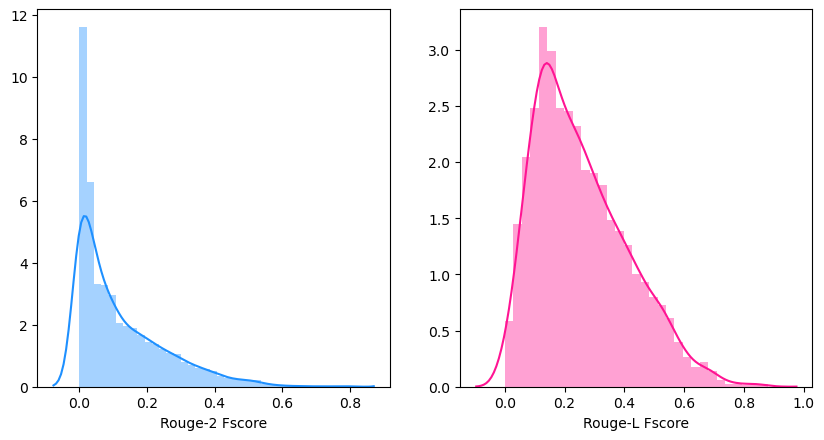

In [14]:
# Define the arguments for plotting
kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})
# Plot a histogram
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False, dpi=100)
sns.distplot(train_results['rouge2-f'] , color="dodgerblue", ax=axes[0], axlabel='Rouge-2 Fscore')
sns.distplot(train_results['rougel-f'], color="deeppink", ax=axes[1], axlabel='Rouge-L Fscore')

Plotting the distribution of the metric values in the validation data

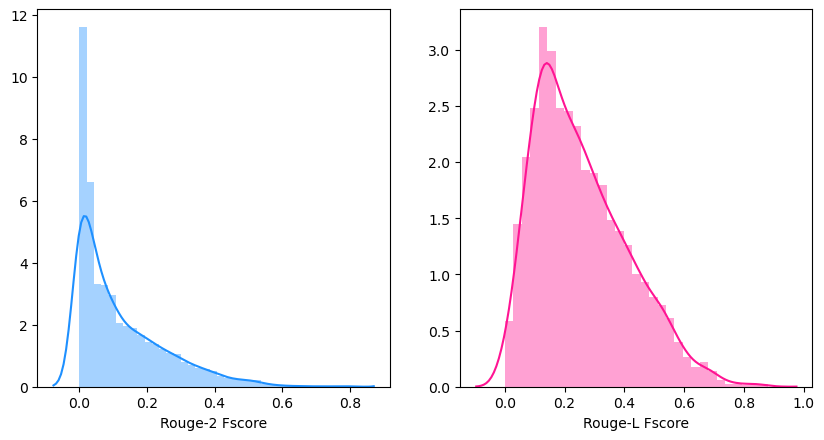

In [15]:
# Define the arguments for plotting
kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})
# Plot a histogram
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False, dpi=100)
sns.distplot(valid_results['rouge2-f'] , color="dodgerblue", ax=axes[0], axlabel='Rouge-2 Fscore')
sns.distplot(valid_results['rougel-f'], color="deeppink", ax=axes[1], axlabel='Rouge-L Fscore')